# Gene essentiality

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas import DataFrame
from cameo import load_model, fba
from cameo.util import TimeMachine
from cameo import exceptions
model = load_model('data/e_coli_core.xml.gz')

## Knocking out a single gene

In the model, exactly one gene is associated with reaction with [phosphoglycerate kinase](http://bigg.ucsd.edu/universal/reactions/PGK) (PGK).

In [2]:
model.reactions.PGK.genes

frozenset({<Gene b2926 at 0x11e36c518>})

Checking the name of this gene in the model (the id is the Blattner number b2926), reveals that it is indeed [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703).

In [3]:
model.genes.b2926.name

'pgk'

Is [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703) essential? Let's find out.

In [4]:
pgk_mutant = model.copy()
pgk_mutant.genes.b2926.knock_out()
pgk_mutant.solve().objective_value

0.0

Yes, it is.

## Perform all possible single gene deletions

Using a `for` loop allows to iterate over all genes in the model and knock out each one of them individually. We're using `TimeMachine` to undo every gene deletion before proceeding to the next knockout.

In [5]:
essentiality = {}
for gene in model.genes:
    with TimeMachine() as tm:
        gene.knock_out(time_machine=tm)
        try:
            solution = model.solve()
        except exceptions.Infeasible:
            solution
        else:
            essentiality[gene] = solution.objective_value

In [7]:
essentiality

{<Gene b2925 at 0x11e3432b0>: 0.8739215069684304,
 <Gene b3916 at 0x11e36c048>: 0.8739215069684296,
 <Gene b1101 at 0x11e365d68>: 0.8739215069684296,
 <Gene b2280 at 0x11e2c4828>: 0.21166294973530198,
 <Gene b0118 at 0x11e3600f0>: 0.8739215069684304,
 <Gene b3612 at 0x11e36c7f0>: 0.8739215069684296,
 <Gene b2579 at 0x11e36c2b0>: 0.8739215069684296,
 <Gene b2297 at 0x11e36cfd0>: 0.8739215069684296,
 <Gene b1773 at 0x11e343668>: 0.8739215069684304,
 <Gene b1812 at 0x11e36a208>: 0.8739215069684296,
 <Gene b3732 at 0x11e35b198>: 0.3742298749331099,
 <Gene b2914 at 0x11e36e5c0>: 0.8739215069684296,
 <Gene b1241 at 0x11e35b1d0>: 0.8739215069684304,
 <Gene b3734 at 0x11e35b208>: 0.3742298749331099,
 <Gene b0485 at 0x11e36a240>: 0.8739215069684296,
 <Gene b0811 at 0x11e365278>: 0.8739215069684296,
 <Gene b0767 at 0x11e36c668>: 0.8638133095040011,
 <Gene b0979 at 0x11e351748>: 0.8739215069684304,
 <Gene b1276 at 0x11e3602b0>: 0.8739215069684304,
 <Gene b0723 at 0x11e36e978>: 0.8142975075325386,

In [8]:
df = DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')

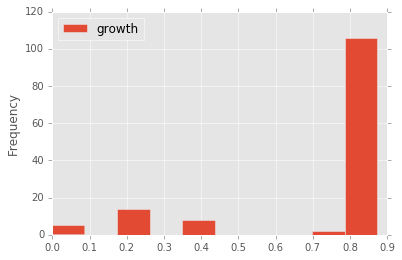

In [9]:
df.plot.hist()

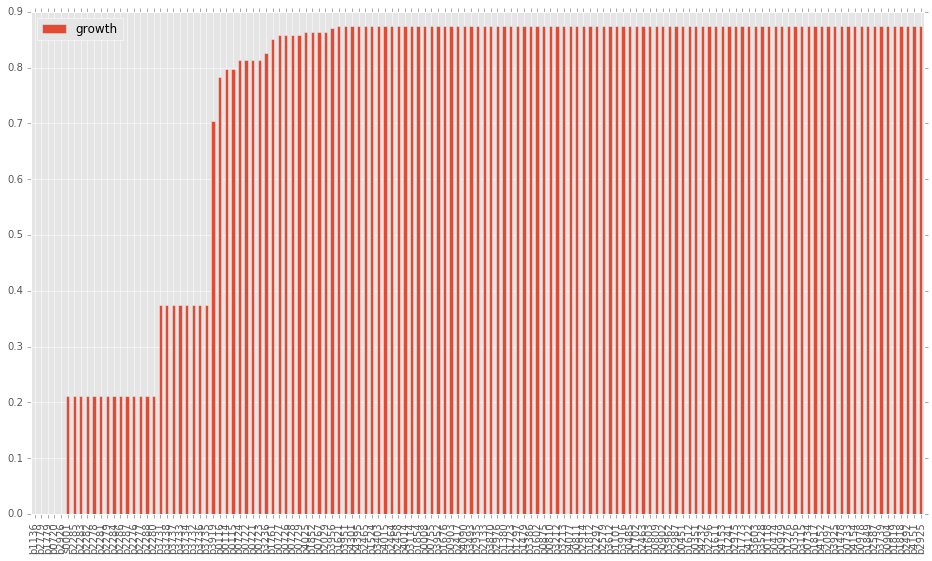

In [10]:
ax = df.plot.bar().axes
ax.figure.set_size_inches(16, 9)

## Exercises

1. How many genes are in each category (essential and non-essential)? How many non-essential genes show a reduced growth rate?
2. Determine the essentialiy of genes for all other available carbon sources (if this is too complicated, determine the essentiality profile for one other carbon source).

Hints:
* Sometimes an optimal solution cannot be found for certain knockouts (an exception is raised). Use `try` and `except` to catch infeasible solutions.

In [11]:
carbon_exchanges = ['EX_ac_e', 'EX_etoh_e', 'EX_for_e',
                    'EX_fru_e', 'EX_fum_e', 'EX_glc__D_e',
                    'EX_lac__D_e', 'EX_mal__L_e', 'EX_pyr_e', 'EX_succ_e']

## Gene essentiality with respect to each biomass precursor

In [12]:
biomass_precursors = model.reactions.BIOMASS_Ecoli_core_w_GAM.reactants
len(biomass_precursors)

16

In [13]:
biomass_precursors

[<Metabolite g3p_c at 0x11e370400>,
 <Metabolite oaa_c at 0x11e36cc88>,
 <Metabolite 3pg_c at 0x11e36c898>,
 <Metabolite g6p_c at 0x11e36c4a8>,
 <Metabolite accoa_c at 0x11e36e0f0>,
 <Metabolite r5p_c at 0x11e370128>,
 <Metabolite pep_c at 0x11e36e2e8>,
 <Metabolite glu__L_c at 0x11e36a588>,
 <Metabolite h2o_c at 0x11e36ce48>,
 <Metabolite e4p_c at 0x11e3702b0>,
 <Metabolite f6p_c at 0x11e3702e8>,
 <Metabolite pyr_c at 0x11e36e358>,
 <Metabolite nadph_c at 0x11e36ef60>,
 <Metabolite atp_c at 0x11e36eb70>,
 <Metabolite gln__L_c at 0x11e36a390>,
 <Metabolite nad_c at 0x11e36efd0>]

In [14]:
model_copy = model.copy()
precursor_essentiality = {}
for precursor in biomass_precursors:
    print('Determining essentiality profile for precursor: ' + precursor.id)
    precursor_essentiality[precursor.name] = {}
    demand = model_copy.add_exchange(precursor)
    model_copy.objective = demand
    for gene in model_copy.genes:
        with TimeMachine() as tm:
            gene.knock_out(time_machine=tm)
            try:
                solution = model_copy.solve()
            except:
                precursor_essentiality[precursor.name][gene.name] = 0
            else:
                precursor_essentiality[precursor.name][gene.name] = solution.objective_value

Determining essentiality profile for precursor: g3p_c
Determining essentiality profile for precursor: oaa_c
Determining essentiality profile for precursor: 3pg_c
Determining essentiality profile for precursor: g6p_c
Determining essentiality profile for precursor: accoa_c
Determining essentiality profile for precursor: r5p_c
Determining essentiality profile for precursor: pep_c
Determining essentiality profile for precursor: glu__L_c
Determining essentiality profile for precursor: h2o_c
Determining essentiality profile for precursor: e4p_c
Determining essentiality profile for precursor: f6p_c
Determining essentiality profile for precursor: pyr_c
Determining essentiality profile for precursor: nadph_c
Determining essentiality profile for precursor: atp_c
Determining essentiality profile for precursor: gln__L_c
Determining essentiality profile for precursor: nad_c


In [15]:
df = DataFrame.from_dict(precursor_essentiality)
df = df.applymap(lambda x: 0 if x < 0.05 else 1)

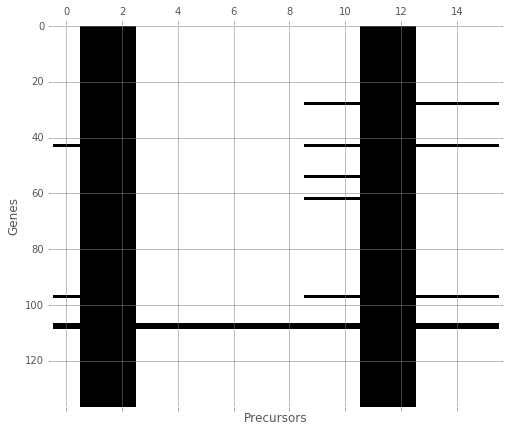

In [16]:
from matplotlib import pyplot as plt
from matplotlib import colorbar
x = plt.matshow(df, cmap='gray')
ax = x.axes
ax.grid(color='gray')
# plt.colorbar(mappable=x, ax=ax)
ax.figure.set_figwidth(8)
ax.set_aspect(.1)
ax.set_xlabel('Precursors')
ax.set_ylabel('Genes')
plt.show()